<a href="https://colab.research.google.com/github/morganmcg1/reformer-fastai/blob/main/exploration/lm_init_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip install -Uqq fastai einops datasets

     |████████████████████████████████| 194kB 19.9MB/s 
     |████████████████████████████████| 163kB 42.2MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 17.7MB 208kB/s 
     |████████████████████████████████| 245kB 58.7MB/s 


In [2]:
from fastai.text.all import *
import datasets
from datasets import load_dataset
import six

In [3]:
dataset = load_dataset('tiny_shakespeare')

Using custom data configuration default


Dataset tiny_shakespeare downloaded and prepared to /root/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/da11b9a200ca715af415094b34d5c956170f184cb3a58d7789680cf81bede955. Subsequent calls will reuse this data.


In [4]:
train_ds = dataset['train']

In [5]:
def splitlines(sample):
    return {'line':[*sample['text'][0].split('\n')]}

In [6]:
train_ds = train_ds.map(splitlines, batched=True, remove_columns=['text'])

In [7]:
train_ds = train_ds.filter(lambda x: x['line'] != '')

In [8]:
train_ds[:10]

OrderedDict([('line',
              ['First Citizen:',
               'Before we proceed any further, hear me speak.',
               'All:',
               'Speak, speak.',
               'First Citizen:',
               'You are all resolved rather to die than to famish?',
               'All:',
               'Resolved. resolved.',
               'First Citizen:',
               'First, you know Caius Marcius is chief enemy to the people.'])])

In [9]:
df = train_ds.data.to_pandas()
df.head()

,line
0,First Citizen:
1,"Before we proceed any further, hear me speak."
2,All:
3,"Speak, speak."
4,First Citizen:


TODO: update to import

In [10]:
class ByteTextTokenizer(Transform):
    """
        Encodes each byte to an id. For 8-bit strings only.
        Credit: https://github.com/tensorflow/tensor2tensor/blob/5f9dd2db6d7797162e53adf152310ed13e9fc711/tensor2tensor/data_generators/text_encoder.py#L176
    """
    def __init__(self, is_lm=True, add_bos=False, add_eos=False):
        self.ls_lm = is_lm
        self.add_bos, self.add_eos = add_bos, add_eos
        self.pad_token, self.eos_token, self.bos_token = '<pad>', '<eos>', '<bos>',
        self.pad_token_id, self.eos_token_id, self.bos_token_id = 0,1,2
        self.reserved_toks = [self.pad_token, self.eos_token, self.bos_token]  ## self.bos_token_id 
        self.reserved_tokens_bytes = [bytes(rtok, 'ascii') for rtok in self.reserved_toks]
        self.numres = len(self.reserved_toks)
        self.int2byte = six.int2byte

    @typedispatch
    def __call__(self, o:list, **kwargs):
        out = [c + self.numres for s in o for c in s.encode("utf-8")]
        if self.add_bos: out = [self.bos_token_id] + out
        if self.add_eos: out =  out + [self.eos_token_id]
        if self.ls_lm:return LMTensorText(out)
        else: return TensorText(out) 
        
    @typedispatch
    def __call__(self, o:str, **kwargs):
        out = [c + self.numres for c in o.encode("utf-8")]
        if self.add_bos: out = [self.bos_token_id] + out
        if self.add_eos: out =  out + [self.eos_token_id]
        if self.ls_lm:return LMTensorText(out)
        else: return TensorText(out) 
    
    def encodes(self,o):
        return self.__call__(o)
    
    def decodes(self, o:tuple):
        decoded_ids = ()
        for i in o:
            tmp_ls=[]
            for id_ in i:
                if 0 <= id_ < self.numres: tmp_ls.append(self.reserved_tokens_bytes[int(id_)])
                else: tmp_ls.append(self.int2byte(id_ - self.numres))
            decoded_ids = decoded_ids + (b"".join(tmp_ls).decode("utf-8", "replace"),)
        return TitledStr(decoded_ids)
    
    def decodes(self, o:list):
        decoded_ids = []
        for id_ in o:
            if 0 <= id_ < self.numres: decoded_ids.append(self.reserved_tokens_bytes[int(id_)])
            else: decoded_ids.append(self.int2byte(id_ - self.numres))
        return TitledStr(b"".join(decoded_ids).decode("utf-8", "replace"))
    
    def decodes(self, o:TensorText):
        return self.decodes(o.tolist())
    
    def decodes(self, o:LMTensorText):
        return self.decodes(o.tolist())
    
    @property
    def vocab_size(self): return 2**8 + self.numres

In [11]:
bte = ByteTextTokenizer(is_lm=True, add_bos=True, add_eos=True)

In [12]:
@patch
def create_item(self:LMDataLoader, seq):
    if seq>=self.n: raise IndexError
    sl = self.last_len if seq//self.bs==self.n_batches-1 else self.seq_len
    st = (seq%self.bs)*self.bl + (seq//self.bs)*self.seq_len
    txt = self.chunks[st : st+sl+1]    
    return LMTensorText(txt[:-1]),txt[1:]
    # return LMTensorText(txt[:-1].tolist()+[1]), LMTensorText(txt[1:].tolist()+[1])   ## ADD EOS TOKEN

In [13]:
cut = int(len(df)*0.8)
splits = range_of(df)[:cut], range_of(df[cut:])

In [14]:
tfms = [attrgetter("line"), bte]
dsets = Datasets(df, [tfms, tfms], splits=splits, dl_type=LMDataLoader)

In [15]:
dsets[0]

(LMTensorText([  2,  73, 108, 117, 118, 119,  35,  70, 108, 119, 108, 125, 104, 113,
          61,   1]),
 LMTensorText([  2,  73, 108, 117, 118, 119,  35,  70, 108, 119, 108, 125, 104, 113,
          61,   1]))

In [16]:
bte.decode(_[0])

'<bos>First Citizen:<eos>'

In [17]:
vocab_sz = bte.vocab_size
bs,sl = 64,128
pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])

dls = dsets.dataloaders(bs=bs, seq_len=sl, before_batch=pad_seq2seq, device=torch.device('cuda'))

In [18]:
dls.show_batch(max_n=2)

,text,text_
0,"<bos>LEONTES:<eos><bos>By playing it to me with so sour a face.<eos><bos>With wine and feeding, we have suppler souls<eos><bos>CORIOLANUS:<eos><bos>Within me grief","LEONTES:<eos><bos>By playing it to me with so sour a face.<eos><bos>With wine and feeding, we have suppler souls<eos><bos>CORIOLANUS:<eos><bos>Within me grief h"
1,"be the issue!<eos><bos>To stop devoted charitable deeds?<eos><bos>Kill, kill, kill, kill, kill him!<eos><bos>Say no more:<eos><bos>This but done,<eos><bos>Before I pos","be the issue!<eos><bos>To stop devoted charitable deeds?<eos><bos>Kill, kill, kill, kill, kill him!<eos><bos>Say no more:<eos><bos>This but done,<eos><bos>Before I posi"


In [19]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 128]), torch.Size([64, 128]))

In [20]:
!wget https://raw.githubusercontent.com/morganmcg1/reformer-fastai/main/basic_transformer.py

--2020-11-21 21:53:15--  https://raw.githubusercontent.com/morganmcg1/reformer-fastai/main/basic_transformer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21210 (21K) [text/plain]
Saving to: ‘basic_transformer.py’

basic_transformer.p 100%[===================>]  20.71K  --.-KB/s    in 0s      

2020-11-21 21:53:15 (67.5 MB/s) - ‘basic_transformer.py’ saved [21210/21210]



In [21]:
from basic_transformer import TransformerLM

## Training

In [22]:
learn = Learner(dls, TransformerLM(vocab_sz, 512),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_native_fp16()

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.04786301031708717)

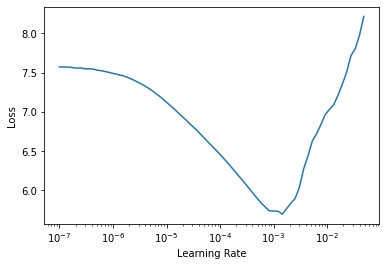

In [23]:
learn.lr_find()

In [24]:
learn.fit_one_cycle(10, 5e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.434133,2.711103,0.246508,15.045869,00:51
1,2.698276,2.491962,0.286407,12.084966,00:52
2,2.434373,2.257761,0.339897,9.561657,00:52
3,2.210517,2.087826,0.385237,8.067358,00:52
4,2.051760,1.923386,0.429779,6.844097,00:53
5,1.924850,1.799508,0.461241,6.046672,00:52
6,1.830511,1.724915,0.482219,5.612043,00:52
7,1.766610,1.679162,0.493519,5.361061,00:52
8,1.729855,1.653258,0.499979,5.223973,00:52
9,1.713640,1.647914,0.500384,5.196131,00:52


In [ ]:
learn.save('shakespeare_e10')

Path('models/shakespeare_e10.pth')

In [ ]:
# learn.load('shakespeare_e10')

## Init experiments 

[pytorch init docs](https://pytorch.org/docs/stable/nn.init.html?highlight=xavier_unifor#torch.nn.init.xavier_uniform_)

TODOs: 
- [ ] rerun experiments with latest changes for fair comparison
- [ ] checkout ativation stats using https://docs.fast.ai/callback.hook.html#ActivationStats
- [ ] try combining different init's with different positional encodings
- [ ] run experiments untill overfitting
- [ ] try fixup init https://arxiv.org/pdf/1901.09321v1.pdf
- [ ] explore weight decay effect

In [ ]:
# for n, m in learn.model.named_modules():
#     print(n)
#     print(m)

### Prenorm

In [25]:
del learn
torch.cuda.empty_cache()

In [26]:
learn = Learner(dls, TransformerLM(vocab_sz, 512, prenorm=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_native_fp16()

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=0.0006918309954926372)

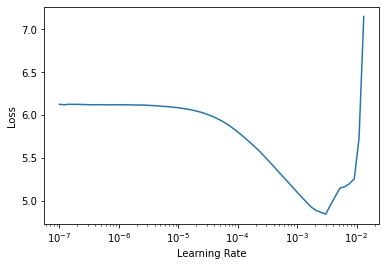

In [27]:
learn.lr_find()

In [28]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.064536,2.563962,0.262811,12.987170,00:52
1,2.548618,2.393521,0.304189,10.951983,00:52
2,2.241713,2.071814,0.386870,7.939212,00:52
3,2.015799,1.874189,0.439860,6.515533,00:53
4,1.860401,1.740188,0.474998,5.698415,00:52
5,1.756969,1.658816,0.498171,5.253089,00:52
6,1.688443,1.597034,0.512001,4.938366,00:52
7,1.637916,1.563455,0.521040,4.775290,00:52
8,1.609045,1.544818,0.526250,4.687118,00:52
9,1.593604,1.540156,0.527135,4.665317,00:52


In [26]:
del learn
torch.cuda.empty_cache()

In [28]:
learn = Learner(dls, TransformerLM(vocab_sz, 512, prenorm=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_native_fp16()
learn.fit_one_cycle(10, 5e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.183944,2.542723,0.271228,12.714250,00:48
1,2.548309,2.396510,0.300907,10.984772,00:48
2,2.339589,2.225435,0.346853,9.257513,00:48
3,2.136496,2.018245,0.399328,7.525110,00:48
4,1.988222,1.863818,0.442517,6.448308,00:48
5,1.866449,1.752337,0.473180,5.768069,00:48
6,1.775126,1.674249,0.493405,5.334788,00:48
7,1.715463,1.629757,0.504601,5.102635,00:48
8,1.678048,1.610129,0.509914,5.003458,00:48
9,1.665579,1.606045,0.510820,4.983064,00:49


In [29]:
del learn
torch.cuda.empty_cache()

In [30]:
learn = Learner(dls, TransformerLM(vocab_sz, 512, prenorm=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_fp16()
learn.fit_one_cycle(10, 5e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.259197,2.552690,0.270886,12.841596,00:45
1,2.558815,2.394013,0.296910,10.957379,00:44
2,2.346196,2.220614,0.347189,9.212988,00:45
3,2.136448,2.014906,0.400715,7.500023,00:44
4,1.983526,1.864766,0.441793,6.454423,00:45
5,1.862125,1.750739,0.473341,5.758857,00:45
6,1.773427,1.672687,0.493862,5.326459,00:45
7,1.716216,1.631203,0.503833,5.110016,00:44
8,1.680556,1.608295,0.510621,4.994287,00:44
9,1.667235,1.604834,0.511647,4.977035,00:44


In [ ]:
del learn
torch.cuda.empty_cache()

In [ ]:
learn = Learner(dls, TransformerLM(vocab_sz, 512, prenorm=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()])
learn.fit_one_cycle(10, 5e-4)

In [31]:
del learn
torch.cuda.empty_cache()

In [32]:
learn = Learner(dls, TransformerLM(vocab_sz, 512, prenorm=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_native_fp16()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.891958,2.478371,0.277939,11.921827,00:48
1,2.477611,2.350193,0.316516,10.487594,00:48
2,2.165815,1.981662,0.410236,7.254793,00:48
3,1.907013,1.748724,0.476671,5.747267,00:48
4,1.728892,1.608966,0.510913,4.997641,00:48
5,1.616187,1.512021,0.535748,4.535888,00:48
6,1.536448,1.440581,0.555699,4.223147,00:49
7,1.476998,1.397911,0.566932,4.046736,00:48
8,1.439846,1.374955,0.571689,3.954898,00:49
9,1.420235,1.370043,0.573941,3.935521,00:48


In [33]:
# best 10 epoch run (no dropout between attention and ff)
# to be matched with new config
# del learn
# torch.cuda.empty_cache()
# learn = Learner(dls, TransformerLM(vocab_sz, 512, prenorm=True),
#                 loss_func=CrossEntropyLossFlat(),
#                 metrics=[accuracy, Perplexity()]).to_native_fp16()
# learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.655741,2.431093,0.281693,11.371304,00:48
1,2.285263,2.124635,0.357686,8.369838,00:48
2,1.905690,1.724872,0.488441,5.611800,00:48
3,1.690781,1.556856,0.525716,4.743884,00:48
4,1.572201,1.452617,0.553523,4.274285,00:48
5,1.482140,1.373206,0.574506,3.947988,00:48
6,1.403928,1.302566,0.590271,3.678724,00:48
7,1.335006,1.243060,0.606078,3.466203,00:48
8,1.279115,1.204529,0.617094,3.335189,00:48
9,1.245498,1.197605,0.619160,3.312175,00:48


TODO: RAdam

?? RAdam may be better suited for postnorm (see On Layer Normalization ... paper)

may be try to switch from `fit_one_cycle`

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0831763744354248)

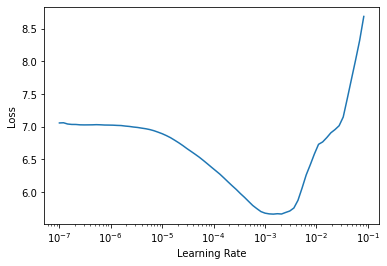

In [34]:
del learn
torch.cuda.empty_cache()
learn = Learner(dls, TransformerLM(vocab_sz, 512), 
                opt_func=RAdam,
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_native_fp16()
learn.lr_find()

In [35]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.447624,2.639021,0.259315,13.999497,00:48
1,2.673485,2.369207,0.309797,10.688909,00:48
2,2.315126,2.107843,0.383845,8.230467,00:48
3,2.013153,1.826135,0.452079,6.209836,00:49
4,1.794469,1.627447,0.506133,5.090860,00:48
5,1.644663,1.515034,0.537587,4.549577,00:48
6,1.541715,1.436065,0.557329,4.204118,00:48
7,1.471609,1.381216,0.569824,3.979738,00:48
8,1.421853,1.342212,0.581111,3.827501,00:48
9,1.394570,1.335156,0.582773,3.800589,00:49


!! Instability in the begining - worse than 1e-3

In [36]:
del learn
torch.cuda.empty_cache()
learn = Learner(dls, TransformerLM(vocab_sz, 512), 
                opt_func=RAdam,
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_native_fp16()
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.205074,2.622827,0.265125,13.774607,00:48
1,4.199325,3.344301,0.173488,28.340765,00:48
2,2.658805,2.254802,0.348942,9.533405,00:48
3,2.232302,2.060265,0.393698,7.848048,00:48
4,2.046109,1.923409,0.425275,6.844251,00:48
5,1.897570,1.754345,0.468364,5.779660,00:48
6,1.777555,1.657268,0.496559,5.244963,00:48
7,1.697490,1.599239,0.509301,4.949267,00:48
8,1.641900,1.559162,0.520308,4.754836,00:48
9,1.616546,1.548959,0.522302,4.706567,00:48


TODO Adafactor

### default + fixed pos encodings

In [38]:
del learn
torch.cuda.empty_cache()

In [39]:
learn = Learner(dls, TransformerLM(vocab_sz, 512, pos_enc='fixed'),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_native_fp16()

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0691830962896347)

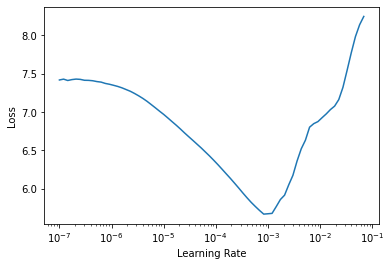

In [40]:
learn.lr_find()

In [41]:
learn.fit_one_cycle(10, 5e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.429643,2.707728,0.249525,14.995170,00:52
1,2.699254,2.476765,0.284308,11.902701,00:52
2,2.435304,2.261078,0.343424,9.593427,00:53
3,2.210564,2.065459,0.389746,7.888920,00:52
4,2.053837,1.922634,0.427202,6.838946,00:52
5,1.927998,1.808566,0.459501,6.101694,00:53
6,1.832595,1.720668,0.482306,5.588262,00:52
7,1.768773,1.674900,0.494437,5.338261,00:53
8,1.728668,1.651860,0.501291,5.216673,00:53
9,1.711644,1.647894,0.502114,5.196024,00:53


### bert init

In [ ]:
learn = Learner(dls, TransformerLM(vocab_sz, 512),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_native_fp16()

In [ ]:
def print_parameter_stats(model):
    for n, m in model.named_modules():
        if hasattr(m, 'weight'):
            print(n)
            print(f'    weights mean {m.weight.mean().item():.6f}, std {m.weight.std().item():.6f}')
        # else:
        #     print(n, ' has no weight')

In [ ]:
print_parameter_stats(learn.model)

emb.emb
weights mean 0.000032, std 0.019960
emb.pos_enc.emb
weights mean -0.001253, std 1.003188
tfmr.layers.0.attn.fn.fn.to_q
weights mean 0.000067, std 0.025527
tfmr.layers.0.attn.fn.fn.to_kv
weights mean 0.000070, std 0.025502
tfmr.layers.0.attn.fn.fn.to_out
weights mean 0.000022, std 0.025491
tfmr.layers.0.attn.fn.norm
weights mean 1.000000, std 0.000000
tfmr.layers.0.ff.fn.fn.net.0
weights mean -0.000014, std 0.025508
tfmr.layers.0.ff.fn.fn.net.3
weights mean 0.000002, std 0.012760
tfmr.layers.0.ff.fn.norm
weights mean 1.000000, std 0.000000
tfmr.layers.1.attn.fn.fn.to_q
weights mean -0.000007, std 0.025495
tfmr.layers.1.attn.fn.fn.to_kv
weights mean 0.000008, std 0.025507
tfmr.layers.1.attn.fn.fn.to_out
weights mean 0.000057, std 0.025494
tfmr.layers.1.attn.fn.norm
weights mean 1.000000, std 0.000000
tfmr.layers.1.ff.fn.fn.net.0
weights mean 0.000017, std 0.025520
tfmr.layers.1.ff.fn.fn.net.3
weights mean 0.000024, std 0.012760
tfmr.layers.1.ff.fn.norm
weights mean 1.000000, std 

In [ ]:
def bert_init(model):
    """ Initialize the weights """
    for module in model.modules():
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=0.02)
        # default to pytorch, to remove
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

In [ ]:
bert_init(learn.model)
print_parameter_stats(learn.model)

emb.emb
weights mean -0.000016, std 0.020013
emb.pos_enc.emb
weights mean 0.000007, std 0.019987
tfmr.layers.0.attn.fn.fn.to_q
weights mean 0.000022, std 0.020013
tfmr.layers.0.attn.fn.fn.to_kv
weights mean 0.000039, std 0.020014
tfmr.layers.0.attn.fn.fn.to_out
weights mean -0.000020, std 0.020039
tfmr.layers.0.attn.fn.norm
weights mean 1.000000, std 0.000000
tfmr.layers.0.ff.fn.fn.net.0
weights mean 0.000019, std 0.019999
tfmr.layers.0.ff.fn.fn.net.3
weights mean -0.000015, std 0.019989
tfmr.layers.0.ff.fn.norm
weights mean 1.000000, std 0.000000
tfmr.layers.1.attn.fn.fn.to_q
weights mean 0.000069, std 0.020000
tfmr.layers.1.attn.fn.fn.to_kv
weights mean 0.000057, std 0.019997
tfmr.layers.1.attn.fn.fn.to_out
weights mean 0.000091, std 0.020047
tfmr.layers.1.attn.fn.norm
weights mean 1.000000, std 0.000000
tfmr.layers.1.ff.fn.fn.net.0
weights mean -0.000014, std 0.019979
tfmr.layers.1.ff.fn.fn.net.3
weights mean -0.000028, std 0.020000
tfmr.layers.1.ff.fn.norm
weights mean 1.000000, st

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=7.585775892948732e-05)

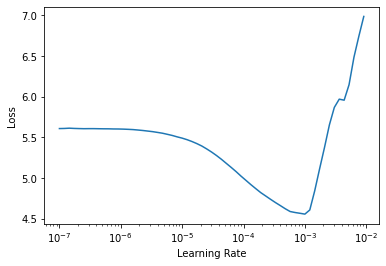

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.001231,2.584840,0.282925,13.261165,00:52
1,2.434564,2.346462,0.314638,10.448535,00:52
2,2.338681,2.281197,0.332321,9.788386,00:52
3,2.261158,2.167946,0.359999,8.740310,00:53
4,2.157986,2.058212,0.389097,7.831952,00:52
5,2.065553,1.964524,0.412205,7.131520,00:52
6,1.997321,1.898286,0.430962,6.674441,00:52
7,1.952435,1.861121,0.443805,6.430941,00:52
8,1.932240,1.838866,0.449773,6.289404,00:52
9,1.923388,1.834828,0.451060,6.264058,00:53


In [ ]:
learn.save('bert_init_10e')

Path('models/bert_init_10e.pth')

### xavier init everywhere

In [ ]:
del learn
torch.cuda.empty_cache()

In [ ]:
learn = Learner(dls, TransformerLM(vocab_sz, 512),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_native_fp16()

In [ ]:
def xavier_init(model):
    """ Initialize the weights """
    for name, module in model.named_modules():
        if (isinstance(module, (nn.Linear, nn.Embedding)) and not 
            name.endswith('ff.fn.fn.net.0')): #skip first ff linear layer
            print(f'Initializing {name}')
            nn.init.xavier_uniform_(module.weight)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

In [ ]:
xavier_init(learn.model)
# print_parameter_stats(learn.model)

Initializing emb.emb
Initializing emb.pos_enc.emb
Initializing tfmr.layers.0.attn.fn.fn.to_q
Initializing tfmr.layers.0.attn.fn.fn.to_kv
Initializing tfmr.layers.0.attn.fn.fn.to_out
Initializing tfmr.layers.0.ff.fn.fn.net.3
Initializing tfmr.layers.1.attn.fn.fn.to_q
Initializing tfmr.layers.1.attn.fn.fn.to_kv
Initializing tfmr.layers.1.attn.fn.fn.to_out
Initializing tfmr.layers.1.ff.fn.fn.net.3
Initializing tfmr.layers.2.attn.fn.fn.to_q
Initializing tfmr.layers.2.attn.fn.fn.to_kv
Initializing tfmr.layers.2.attn.fn.fn.to_out
Initializing tfmr.layers.2.ff.fn.fn.net.3
Initializing tfmr.layers.3.attn.fn.fn.to_q
Initializing tfmr.layers.3.attn.fn.fn.to_kv
Initializing tfmr.layers.3.attn.fn.fn.to_out
Initializing tfmr.layers.3.ff.fn.fn.net.3
Initializing tfmr.layers.4.attn.fn.fn.to_q
Initializing tfmr.layers.4.attn.fn.fn.to_kv
Initializing tfmr.layers.4.attn.fn.fn.to_out
Initializing tfmr.layers.4.ff.fn.fn.net.3
Initializing tfmr.layers.5.attn.fn.fn.to_q
Initializing tfmr.layers.5.attn.fn.fn

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0691830962896347)

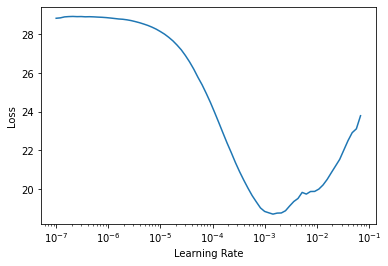

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 3e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.160641,2.714973,0.252509,15.104198,00:52
1,3.291717,2.438443,0.297912,11.455194,00:52
2,2.687493,2.388665,0.306014,10.898932,00:52
3,2.509730,2.337611,0.305135,10.356467,00:52
4,2.408470,2.247009,0.330939,9.459401,00:52
5,2.306112,2.131926,0.374891,8.431092,00:52
6,2.191145,2.004643,0.407045,7.423447,00:52
7,2.094439,1.935884,0.426789,6.930164,00:52
8,2.037987,1.894476,0.437511,6.649063,00:52
9,2.015136,1.886768,0.439071,6.598008,00:52


### xavier_init attention only

In [ ]:
from basic_transformer import Attention

In [ ]:
del learn
torch.cuda.empty_cache()

In [ ]:
learn = Learner(dls, TransformerLM(vocab_sz, 512),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_native_fp16()

In [ ]:
def xavier_init(model):
    """ Initialize the weights """
    for name, module in model.named_modules():
        if (isinstance(module, (nn.Linear)) and not 
            'ff.' in name): #skip ff linear layers
            print(f'Initializing {name}')
            nn.init.xavier_normal_(module.weight)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

In [ ]:
xavier_init(learn.model)
# print_parameter_stats(learn.model)

Initializing emb.emb
Initializing emb.pos_enc.emb
Initializing tfmr.layers.0.attn.fn.fn.to_q
Initializing tfmr.layers.0.attn.fn.fn.to_kv
Initializing tfmr.layers.0.attn.fn.fn.to_out
Initializing tfmr.layers.1.attn.fn.fn.to_q
Initializing tfmr.layers.1.attn.fn.fn.to_kv
Initializing tfmr.layers.1.attn.fn.fn.to_out
Initializing tfmr.layers.2.attn.fn.fn.to_q
Initializing tfmr.layers.2.attn.fn.fn.to_kv
Initializing tfmr.layers.2.attn.fn.fn.to_out
Initializing tfmr.layers.3.attn.fn.fn.to_q
Initializing tfmr.layers.3.attn.fn.fn.to_kv
Initializing tfmr.layers.3.attn.fn.fn.to_out
Initializing tfmr.layers.4.attn.fn.fn.to_q
Initializing tfmr.layers.4.attn.fn.fn.to_kv
Initializing tfmr.layers.4.attn.fn.fn.to_out
Initializing tfmr.layers.5.attn.fn.fn.to_q
Initializing tfmr.layers.5.attn.fn.fn.to_kv
Initializing tfmr.layers.5.attn.fn.fn.to_out
Initializing proj


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0831763744354248)

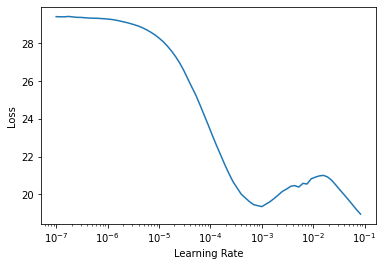

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 3e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.404907,2.615386,0.273311,13.672497,00:51
1,3.415970,2.425563,0.294748,11.308590,00:51
2,2.656610,2.385715,0.300739,10.866827,00:51
3,2.490022,2.322018,0.318148,10.196229,00:51
4,2.400759,2.252531,0.338253,9.511780,00:52
5,2.312801,2.151194,0.364019,8.595114,00:52
6,2.204844,2.027935,0.397380,7.598376,00:51
7,2.107135,1.937648,0.422732,6.942401,00:52
8,2.042227,1.899956,0.434424,6.685601,00:52
9,2.016414,1.890221,0.435807,6.620832,00:52
